In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1


# update the neighbors
class segment_iter(directives.InversionDirective):

    seg_iter = 4
    
    def initialize(self):
        self.count = 0
    
    def endIter(self):

        print(f"Segmenting-iteration: {self.opt.iter}")
        if self.count == self.seg_iter:
            self.reg[1][1].update_gradients(self.opt.xc)
        
        self.count += 1


3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]



  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_515994/1807258902.py:44: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_515994/1807258902.py:69: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_515994/1807258902.py:73: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: Runtime

0.05004355817063174
6.2844089262865594
0.10194719782126613
0.22453366777027742


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

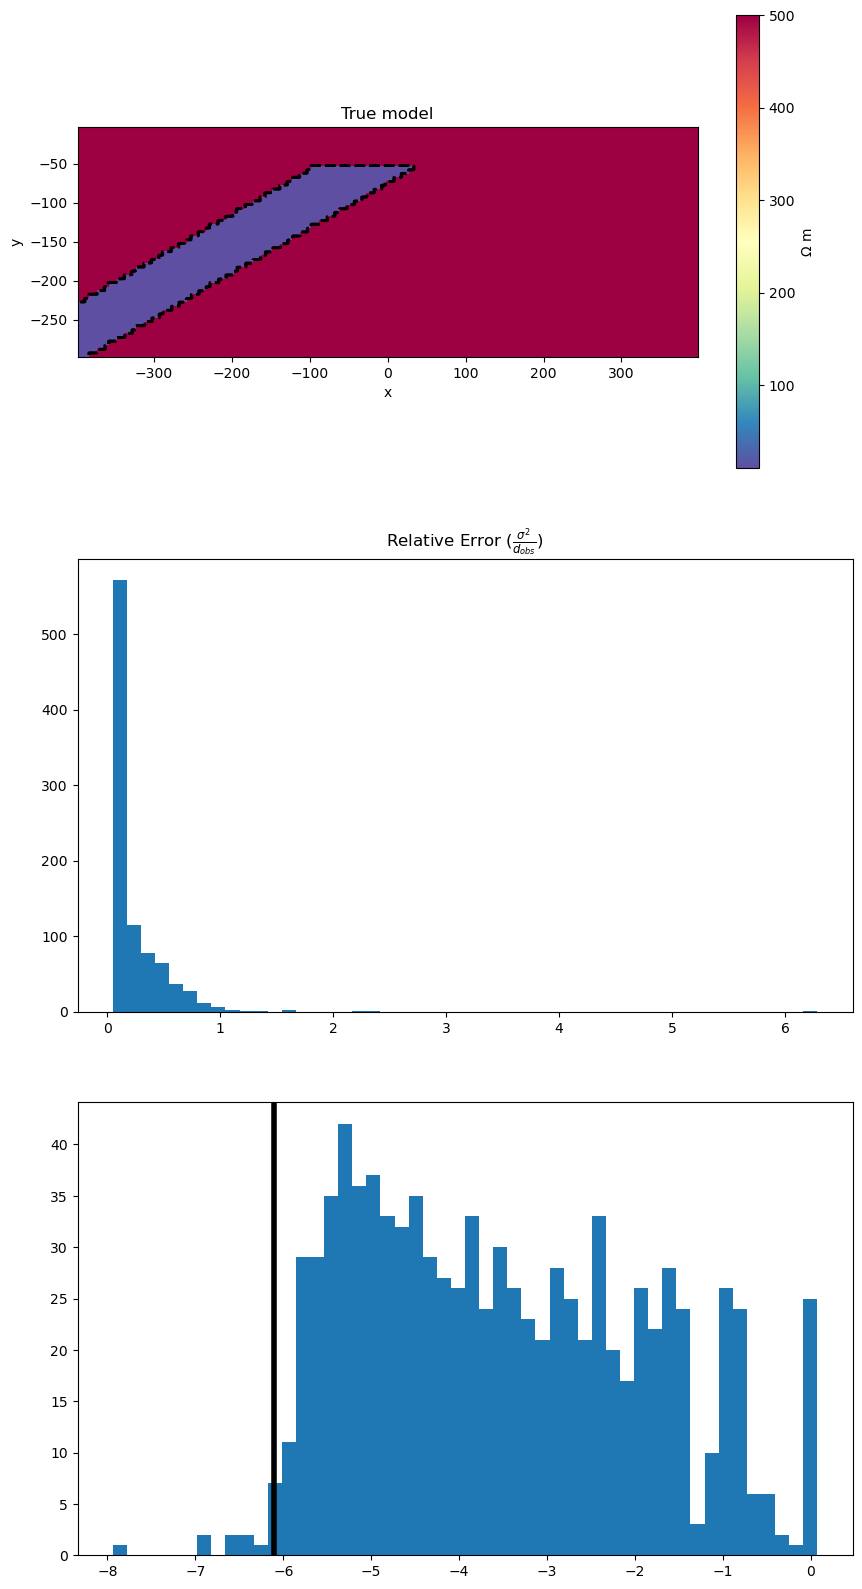

In [2]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -75)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), 0)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

res_true[index_deep] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=5e-4,
    force=True,
    add_noise=True,

)

dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.01)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.01)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

In [3]:
# print(1 / dc_data.noise_floor[0], np.quantile(dc_data.dobs, 0.55), dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean())
# plt.hist(1 / (np.abs(dc_data.dobs * 0.05) + np.quantile(dc_data.dobs, 0.55)), 50)
# # plt.hist(dmis.W.diagonal(), 50)
# # plt.hist(dc_data.standard_deviation + dc_data.noise_floor)

# plt.show()

np.quantile(np.abs(dc_data.dobs), 0.01)

0.002241315810631592

/tmp/ipykernel_515994/1058474633.py:124: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
/tmp/ipykernel_515994/1058474633.py:124: UserWarning: 'threshold' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'threshold_value'.
  updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:318: UserWarning: InversionDirective segment_iter has switched to a new inversion.
  d.inversion = i


SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/home/juanito/miniforge3/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:332: UserWarning: There is no PGI regularization. Smallness target is turned off (TriggerSmall flag).
  getattr(r, ruleType)()


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-01  1.09e+04  0.00e+00  1.09e+04    4.09e+02      0              
Segmenting-iteration: 1
geophys. misfits: 1369.0 (target 460.0 [False])


/tmp/ipykernel_515994/4173020264.py:71: FutureWarning: reference_model.mref has been deprecated, please use reference_model. It will be removed in version 0.19.0 of SimPEG.
  1 / np.exp(self.invProb.reg.objfcts[0].mref), ax=ax[1],


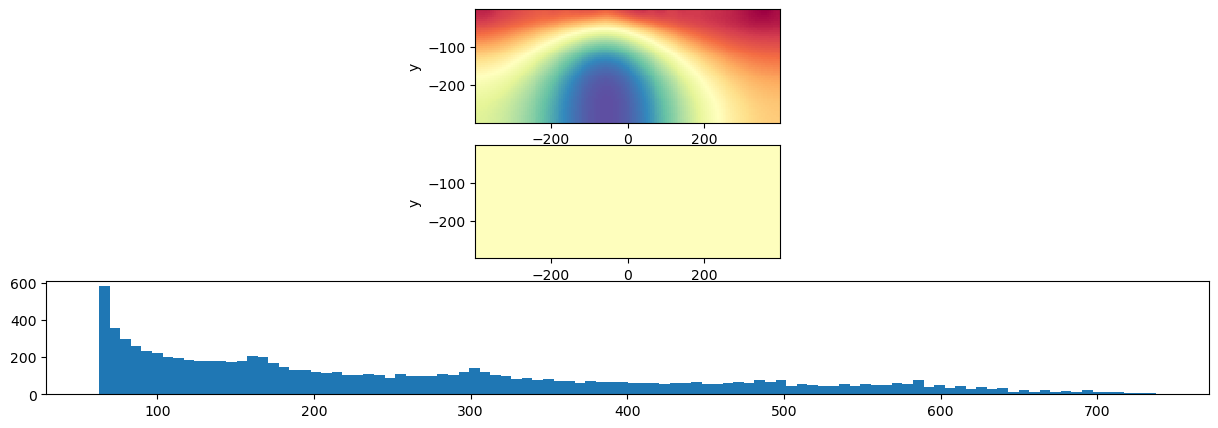

Segmenting-iteration: 1
   1  1.00e-01  1.37e+03  1.76e+04  3.13e+03    1.29e+02      0              
Segmenting-iteration: 2
geophys. misfits: 1340.3 (target 460.0 [False])


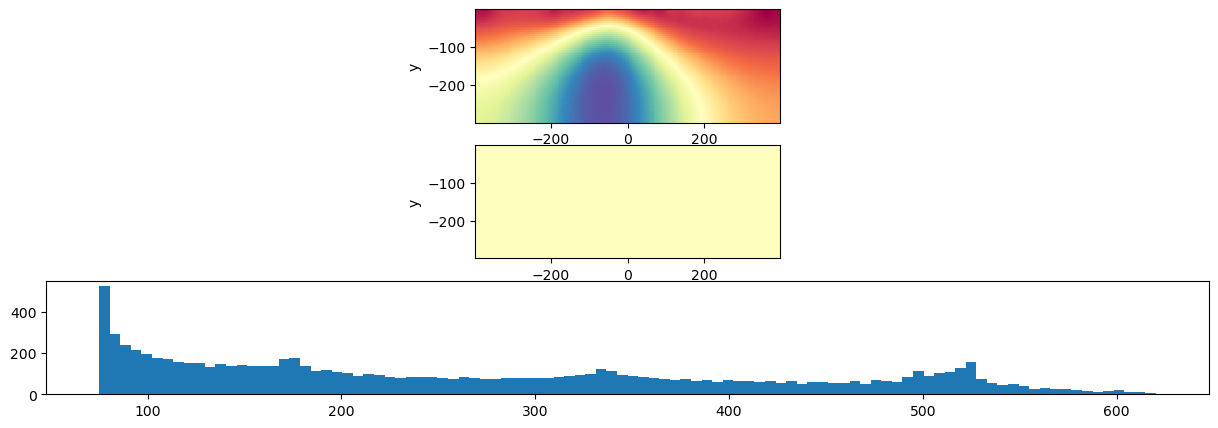

Segmenting-iteration: 2
   2  2.00e-02  1.34e+03  1.48e+04  1.64e+03    8.93e+01      0              
Segmenting-iteration: 3
mask 0 vote total: 1
mask 1 vote total: 1
mask 2 vote total: 0
mask 3 vote total: 1
mask 4 vote total: 0
mask 5 vote total: 0
[1 3]
[[1.00000000e+00 2.88365531e-01 1.45681695e-01 1.52638465e-02
  9.81354269e-03 5.21957067e-02]
 [2.88365531e-01 0.00000000e+00 5.10889627e-01 0.00000000e+00
  0.00000000e+00 1.82355113e-01]
 [1.45681695e-06 5.10889627e-06 1.00000000e+00 0.00000000e+00
  0.00000000e+00 3.56936416e-01]
 [1.52638465e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.60000000e-01 0.00000000e+00]
 [9.81354269e-08 0.00000000e+00 0.00000000e+00 6.60000000e-06
  1.00000000e+00 0.00000000e+00]
 [5.21957067e-07 1.82355113e-06 3.56936416e-06 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Orientation angle (degrees): 45.00000000000005


UnboundLocalError: cannot access local variable 'reg_dirs' where it is not associated with a value

In [4]:
# --------------------------------------------------------------------------

# setup the inversion

#
segmentor = geoseg.SamClassificationModel(
    meshCore,
    segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
)
# theta = -45
# rot= np.vstack([[np.cos(theta * np.pi /180), -np.sin(theta * np.pi /180)], [np.sin(theta * np.pi /180), np.cos(theta * np.pi /180)]])


dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# dmis.w = 1 / np.abs(dc_data.dobs * 0.05 + np.quantile(np.abs(dc_data.dobs), 0.1))
m0 = np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# m0 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/guided/model_11.npy")
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))

# # load mask
# rot_mask = np.load('rotation_block_mask_scaled.npy')

# # set the regularization
# alphas = np.ones((meshCore.n_cells, meshCore.dim))
# # alphas[rot_mask] = [125, 25]
# alphas[meshCore.cell_centers[:, 1] < 0.5] = [125, 25]
# sqrt2 = np.sqrt(2)
# # reg_cell_dirs = 1 / np.array([[sqrt2, -sqrt2], [sqrt2, sqrt2],])
# # lets just assign them to the dip structure
# # reg_cell_dirs = [np.identity(2) for _ in range(meshCore.nC)]

# # lets just assign them to the dip structure
# reg_cell_dirs = [1 / np.array([[sqrt2, sqrt2], [sqrt2, -sqrt2],]) for _ in range(meshCore.nC)]
# print(reg_cell_dirs)
# # lets expand the area we want to
# # Dike 45*
# dike00 = mesh.gridCC[:,1] > fault_function(mesh.gridCC[:,0],1, 50)
# dike01 = mesh.gridCC[:,1] < fault_function(mesh.gridCC[:,0],1, 255)
# dike_dir_reg = np.logical_and(dike00,dike01)

# # reg model
# reg_model = model.copy()

# reg_model[dike_dir_reg]=4

# # cos = np.cos(140*np.pi / 180) * 2
# # sin = np.sin(140*np.pi / 180) * 2

# for ii in range(meshCore.nC):

#     if rot_mask[ii] == 1:
#         print('adjusting')
#         # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
#         reg_cell_dirs[ii] = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
#         alphas[ii] = [150, 25]

reg_seg = geoseg.GeologicalSegmentation(
    meshCore, 
    reg_dirs=None,
    ortho_check=False,
    segmentation_model=segmentor
)

# reg_1storder = regularization.SmoothnessFullGradient(
#     meshCore, 
#     reg_dirs=reg_cell_dirs,
#     alphas=alphas,
#     ortho_check=False,
#     reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# )

reg_small = regularization.Smallness(mesh=meshCore,reference_model=np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP))

# # Weighting
reg_org = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=actcore,
    mapping=idenMap,
    reference_model=m0
)

reg_mean = reg_small + reg_seg # reg_1storder
reg_mean.multipliers = np.r_[5e-4, 100]
# reg_mean = reg_org
# reg_mean.alpha_s = 5e-4
# reg_mean.alpha_x = 100
# reg_mean.alpha_y = 100
# # reg_mean.mrefInSmooth = True
# reg_mean.approx_gradient = True


# Optimization
opt = optimization.ProjectedGNCG(maxIter=5, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)

# Inversion directives
# betaIt = directives.PGI_BetaAlphaSchedule(
#     verbose=True, coolingFactor=3.,
#     warmingFactor=1., tolerance=0.05,
#     progress=0.1
# )
betaIt = directives.BetaSchedule(coolingFactor=5, coolingRate=2)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)
# petrodir = PGIUpdateParameters(
#     update_covariances=True,
#     kappa = 1e8,
#     nu = 1e8,
#     update_rate = 2,
#     update_reference_model=False
#     )
update_sam = segment_iter()
plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
updateSensW = directives.UpdateSensitivityWeights(threshold=5e-1, everyIter=False)
update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-1
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            # updateSensW,
                                            update_sam,
                                            #  petrodir,
                                            targets, betaIt,
                                            #  MrefInSmooth,
                                            plot_iter_mref,
                                            update_sam,
                                            #  save_pgi,
                                            # update_Jacobi,
                                            ])

# Run!

mcluster = inv.run(m0)

# np.save("rotated_model_dip.npy", mcluster)
# np.save("true_model_dip.npy", mtrue)
# # mcluster = np.load("rotated_model.npy")

# # plot
# mm = meshCore.plot_image(
    
#     1/(np.exp(mcluster)),
#     ax=ax[2],
#     clim=[0, 500],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# utils.plot2Ddata(

#     meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[2],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )
# #plt.gca().set_ylim([-200,0])
# ax[2].set_aspect(1)
# plt.colorbar(mm[0], label=r'$\Omega$ m')
# ax[2].set_title('Rotated gradient recovered model')


In [ ]:
reg_mean[1]

(100.0, <geological_segmentation.GeologicalSegmentation at 0x7be6b8185810>)

# Doug and Yaoguo's paper

In [5]:
from scipy.sparse import diags
dip_model = np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_6.npy")


theta = 45 * np.pi / 180

# X term ------------------------------------------------------------------------------
alpha_rot_x = alphas[:, 0] * np.cos(theta)**2 + alphas[:, 1] * np.sin(theta)**2
average_cell_to_face_x = meshCore.average_cell_to_face[: meshCore.nFx]

a = meshCore.face_x_areas
v = average_cell_to_face_x @ meshCore.cell_volumes
cell_gradient_x = sp.diags(a / v) @ meshCore.stencil_cell_gradient_x

r = cell_gradient_x @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
bx = average_cell_to_face_x @ alpha_rot_x

# phix = r[:, None].T @ diags(bx) @ r[:, None]
# print(phix, r[:, None].shape, bx.shape)

# Y term ------------------------------------------------------------------------------
alpha_rot_y = alphas[:, 0] * np.sin(theta)**2 + alphas[:, 1] * np.cos(theta)**2
average_cell_to_face_y = meshCore.average_cell_to_face[
    meshCore.nFx:(meshCore.nFx + meshCore.nFy)
]

a = meshCore.face_y_areas
v = average_cell_to_face_y @ meshCore.cell_volumes
cell_gradient_y = sp.diags(a / v) @ meshCore.stencil_cell_gradient_y

r = cell_gradient_y @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
by = average_cell_to_face_y @ alpha_rot_y

# phiy = r[:, None].T @ diags(by) @ r[:, None]


# XY term ------------------------------------------------------------------------------
alpha_rot_xy = (alphas[:, 0] - alphas[:, 1]) * np.sin(theta) * np.cos(theta)
print(phiy, r[:, None].shape, by.shape, alpha_rot_xy.shape, meshCore.nC)
# average_cell_to_face_xy = meshCore.average_cell_to_face[:(meshCore.nFx + meshCore.nFy)
# ]

ax = meshCore.face_x_areas
vx = average_cell_to_face_x @ meshCore.cell_volumes
cell_gradient_x = sp.diags(ax / vx) @ meshCore.stencil_cell_gradient_x

ay = meshCore.face_y_areas
vy = average_cell_to_face_y @ meshCore.cell_volumes
cell_gradient_y = sp.diags(ay / vy) @ meshCore.stencil_cell_gradient_y

rx = cell_gradient_x @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))
ry = cell_gradient_y @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))

# M_f = meshCore.get_face_inner_product(alpha_rot)
# bxy1 = average_cell_to_face_x @ alpha_rot_xy
# bxy2 = average_cell_to_face_y @ alpha_rot_xy
print(cell_gradient_x.shape, cell_gradient_y.shape, diags(alpha_rot_xy).shape)
# phixy = rx[:, None].T @ diags(alpha_rot_xy) @ ry[:, None] #  + ry[:, None].T @ diags(bxy2) @ rx[:, None]
# print(phixy)

# a1 = sp.kron(average_cell_to_face_y, average_cell_to_face_x)

# construct whole thing
Gxz1 = cell_gradient_x @ diags(alpha_rot_xy) @ cell_gradient_y.T # + cell_gradient_y @ diags(alpha_rot_xy) @ cell_gradient_x.T
print(Gxz1.shape) 


FileNotFoundError: [Errno 2] No such file or directory: '/home/juanito/git/jresearch/geological_segmentation/iterations/model_6.npy'

In [ ]:
# a1 = sp.kron(by, bx)
print(bx.shape)

(1, 90057600)


In [18]:
G = reg_1storder.cell_gradient
W = reg_1storder.W

r = G @ (reg_1storder.mapping * (reg_1storder._delta_m(dip_model)))
print(G.shape, W.shape, r.shape, bx.shape, 18980 / 9440)
# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     mcluster,
#     ax=ax,
#     # clim=[0, 500],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

(18980, 9381) (18980, 18980) (18980,) (9440,) 2.010593220338983


# check comparison

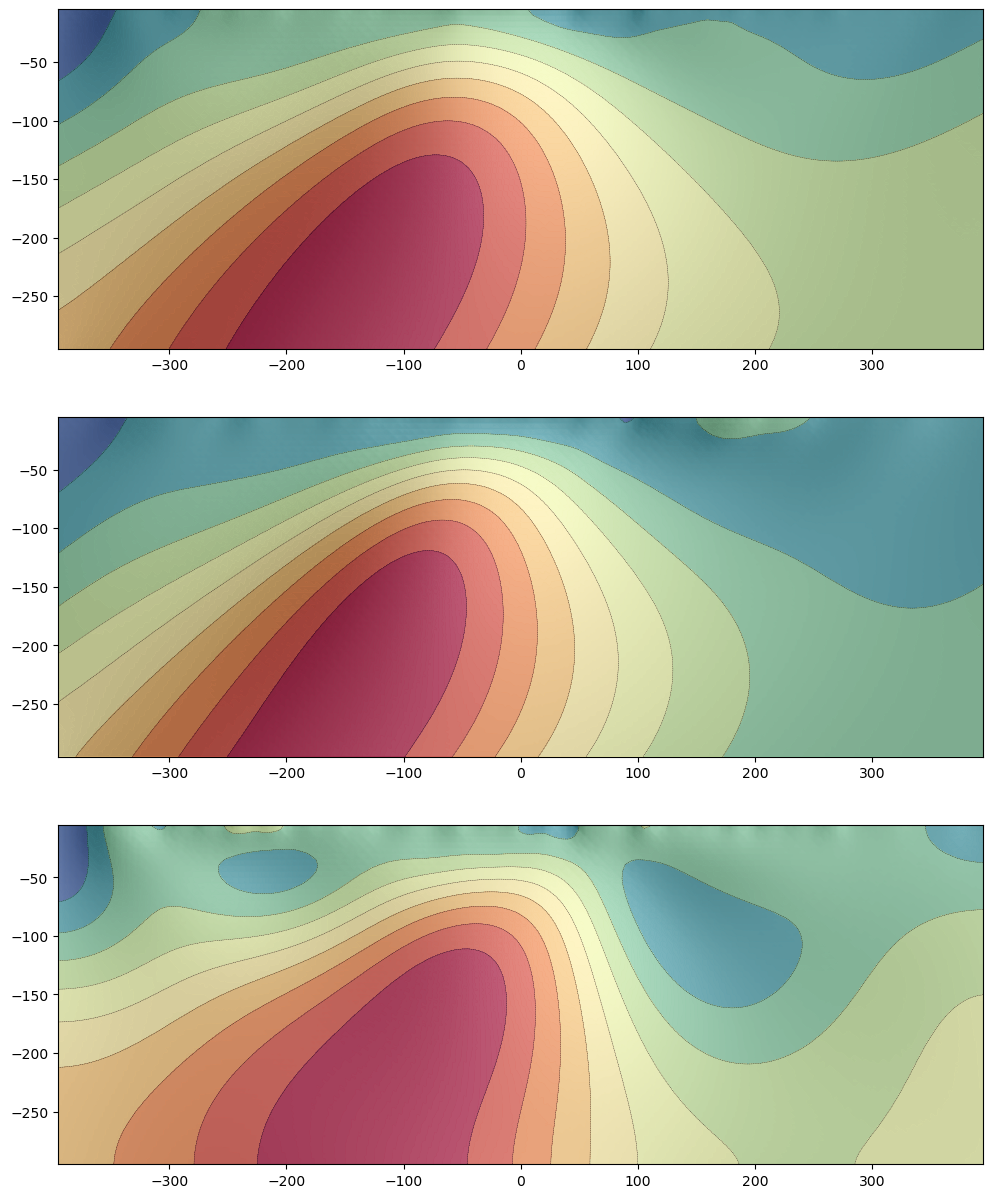

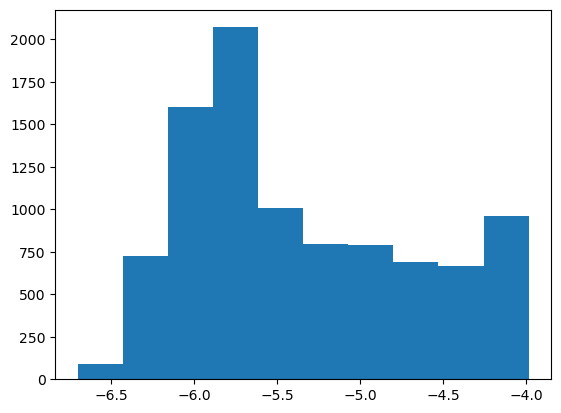

In [33]:
dip_model = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/guided/model_11.npy")
dip_model2 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_4.npy")
dip_model3 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy")

# mcluster = dip_model # reg_mean.deriv(dip_model)
# # print(reg_mean.W)
# G = reg_mean.cell_gradient
# M_f = reg_mean.W
# r = G @ (reg_mean.mapping * (reg_mean._delta_m(dip_model)))
# print((r @ M_f @ r).min())
# plt.hist(r @ M_f @ r)
# return 0.5 * r @ M_f @ r
# print(reg_org._W)

fig, ax = plt.subplots(3,1, figsize=(15,15))

mm2 = utils.plot2Ddata(

    meshCore.gridCC, dip_model3,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=10,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

mm = utils.plot2Ddata(

    meshCore.gridCC, dip_model,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=10,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

mm1 = utils.plot2Ddata(

    meshCore.gridCC, dip_model2,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=10,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)



# plt.colorbar(mm[0], label=r'$\Omega$ m')
plt.show()

# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     # reg_mean.deriv(dip_model),
#     reg_1storder._anis_alpha[:, 0],
#     ax=ax,
#     # clim=[-0.08, 0.08],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

# print(reg_org(dip_model))
# print(reg_mean(dip_model))

# plt.hist(dip_model2)
plt.hist(dip_model)
plt.show()

In [146]:
reg_org.objfcts[0].deriv(dip_model)

array([-159.12927246, -159.13009532, -159.13156349, ..., -163.47652923,
       -162.89668526, -162.62405472])

In [107]:
import numpy as np

def are_vectors_orthonormal(vector1, vector2, tolerance=1e-10):
    # Check if the vectors are orthogonal
    dot_product = np.dot(vector1, vector2)
    is_orthogonal = np.abs(dot_product) < tolerance

    # Check if the vectors are normalized
    magnitude_vector1 = np.linalg.norm(vector1)
    magnitude_vector2 = np.linalg.norm(vector2)
    is_normalized = np.abs(magnitude_vector1 - 1.0) < tolerance and np.abs(magnitude_vector2 - 1.0) < tolerance

    # Return True if both conditions are satisfied
    return is_orthogonal and is_normalized

# Example usage:
vector_a = np.array([sqrt2, -sqrt2])
vector_b = np.array([sqrt2, sqrt2])

if are_vectors_orthonormal(1/vector_a, 1/vector_b):
    print("The vectors are orthonormal.")
else:
    print("The vectors are not orthonormal.")
print(sqrt2, 1/sqrt2)

The vectors are orthonormal.
1.4142135623730951 0.7071067811865475


In [19]:
# model = mcluster # np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_10.npy")
dip_model3 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/L2/model_10.npy")
# segmentor = geoseg.SamClassificationModel(
#     meshCore,
#     segmentation_model_checkpoint=r"/home/juanito/Documents/trained_models/sam_vit_h_4b8939.pth"
# )

masks3 = segmentor.fit(dip_model3)

# model_normalized = np.exp(model) / np.abs(np.exp(model)).max()

# image_rgb = Image.fromarray(np.uint8(cm.jet(model_normalized.reshape(meshCore.shape_cells, order='F'))*255))
# image_rgb = image_rgb.convert('RGB')

# # get the segments
# mask_generator = SamAutomaticMaskGenerator(segmentor.segment_model)
# results = mask_generator.generate(np.asarray(image_rgb))

mask 0 vote total: 0
mask 1 vote total: 1
mask 2 vote total: 0
[]
[[1.000000e+00 0.000000e+00 0.000000e+00]
 [0.000000e+00 1.000000e+00 5.500516e-01]
 [0.000000e+00 5.500516e-06 1.000000e+00]]


In [14]:
print(masks, masks2, masks3)

[{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]]), 'area': 7348, 'bbox': [0, 0, 58, 158], 'predicted_iou': 1.0154991149902344, 'point_coords': [[52.546875, 156.515625]], 'stability_score': 0.9716207385063171, 'crop_box': [0, 0, 59, 159]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 1928, 'bbox': [0, 16, 43, 64], 'predicted_iou': 0.992153525352478, 'p

[0, 0, 58, 158]


In [26]:
meshCore.cell_centers[48]

array([-155., -295.])

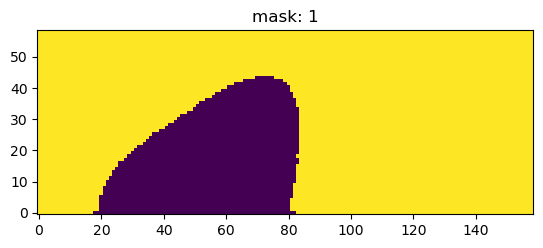

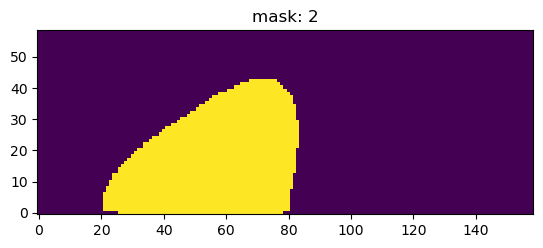

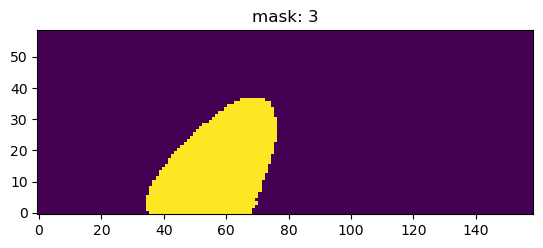

7


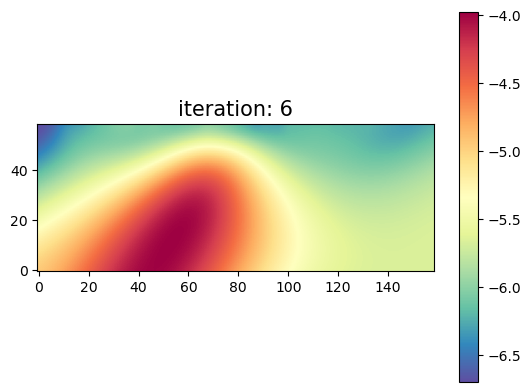

In [24]:
results = masks3
cnt = 1
for result in results:
    flatten = result['segmentation'].flatten(order='F')
    reshape = flatten.reshape(meshCore.shape_cells, order='F')

    plt.imshow(reshape.T)
    plt.title(f'mask: {cnt}')
    plt.gca().invert_yaxis()
    plt.show()
    cnt += 1
print(len(result))

flatten = dip_model
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T, cmap='Spectral_r')
plt.title(f'iteration: {6}',fontsize=15)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [11]:
# masks[5]['area']
# bbox.shape
geological_model = segmentor.predict(dip_model)
fig, ax = plt.subplots(1,1, figsize=(10, 3))
dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

# dat = utils.plot2Ddata(

#     meshCore.gridCC, 1 / np.exp(geological_model),nx=500,ny=500,
#     contourOpts={'cmap':"Spectral", 'alpha':1},
#     #clim=[0,5],
#     ax=ax,
#     # level=True,
#     ncontour=10,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     clim=[10, 500],
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )
# ax.axis("equal")
ax.set_title('Geological classification')
plt.colorbar(dat[0], label=r'$\Omega m$')

TypeError: object of type 'NoneType' has no len()

IndexError: list index out of range

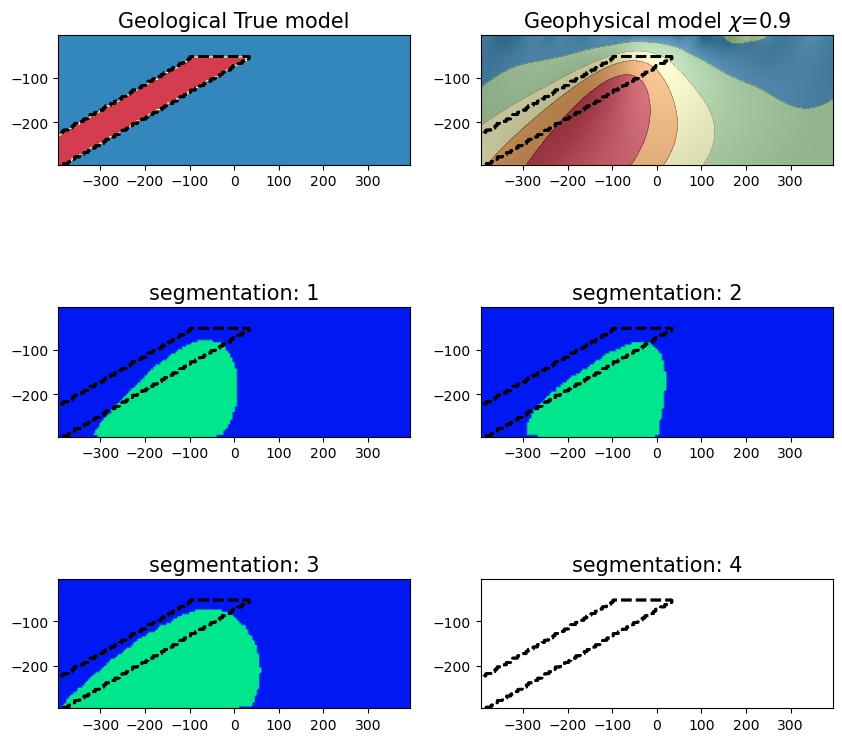

In [29]:
sam_model = segmentor
sam_model.segmentations = masks
cond_true = mtrue
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

# dat = meshCore.plotImage(1 / np.exp(dip_model), ax=ax[0, 1], clim=[10, 500], pcolorOpts={'cmap':"Spectral"})

ax[0, 1].set_title(r'Geophysical model $\chi$=0.9',fontsize=15)


ax[0, 0].set_title('Geological True model',fontsize=15)

ax[1, 0].set_title('segmentation: 1',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[1, 1].set_title('segmentation: 2',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 0].set_title('segmentation: 3',fontsize=15)

# ax[1, 1].invert_yaxis()
ax[2, 1].set_title('segmentation: 4',fontsize=15)

# flatten = sam_model.masks[4]['segmentation'].flatten(order='F')
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[3, 0], pcolorOpts={'cmap':"winter_r"})
# # ax[1, 1].invert_yaxis()
# ax[3, 0].set_title('segmentation: 5',fontsize=15)
# ax[3, 1].axis('off')

# subplot 0,0 ----------------------------------------------------------
flatten = (cond_true)[actcore]
# dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax[0, 0], pcolorOpts={'cmap':"Spectral"})
utils.plot2Ddata(

    meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
    contourOpts={'cmap':"Spectral", 'alpha':1},
    #clim=[0,5],
    ax=ax[0, 0],
    # level=True,
    ncontour=5,
    # shade=True,
    # levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

# subplot 0,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0, 1],
    level=True,
    ncontour=2,
    # shade=True,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC, dip_model2,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[0, 1],
    level=True,
    ncontour=5,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)

# subplot 1,0 ----------------------------------------------------------

flatten = masks[1]['segmentation'].flatten(order='F')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[1, 0],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)

# subplot 1,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

flatten = masks3[1]['segmentation'].flatten(order='F')

utils.plot2Ddata(

    meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[1, 1],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)

# flatten = masks2[1]['segmentation'].flatten(order='F')

# utils.plot2Ddata(

#     meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
#     contourOpts={'cmap':"winter_r", 'alpha':0.5},
#     #clim=[0,5],
#     ax=ax[1, 1],
#     level=False,
#     ncontour=5,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=[10, 500],
    
# )

# flatten = masks[1]['segmentation'].flatten(order='F')

# utils.plot2Ddata(

#     meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
#     contourOpts={'cmap':"winter_r", 'alpha':0.5},
#     #clim=[0,5],
#     ax=ax[1, 1],
#     level=False,
#     ncontour=5,
#     # shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=[10, 500],
    
# )



# subplot 2,0 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

flatten = masks2[1]['segmentation'].flatten(order='F')

utils.plot2Ddata(

    meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[2, 0],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)

# subplot 2,1 ----------------------------------------------------------

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2, 1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

flatten = masks3[3]['segmentation'].flatten(order='F')

utils.plot2Ddata(

    meshCore.gridCC, 1 / np.exp(flatten),nx=500,ny=500,
    contourOpts={'cmap':"winter_r", 'alpha':1},
    #clim=[0,5],
    ax=ax[2, 1],
    level=False,
    ncontour=5,
    # shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=[10, 500],
    
)

plt.tight_layout()

# angles

In [17]:
seg_data = results[2]['segmentation']
seg_data = np.flip(seg_data)
# Find the coordinates of the object pixels
object_pixels = np.argwhere(seg_data == 1)

# Apply PPCA to determine orientation
if len(object_pixels) > 1:
    # Standardize the data
    scaler = StandardScaler()
    object_pixels_std = scaler.fit_transform(object_pixels)

    # Apply PPCA
    pca = PCA(n_components=2)
    pca.fit(object_pixels_std)

    # The first principal component (eigenvector) will represent the orientation
    orientation_vector = pca.components_[0]

    # Compute the angle of the orientation vector (in degrees)
    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

    print(f"Orientation angle (degrees): {angle_degrees}")
    angle_radians = angle_degrees * np.pi / 180

Orientation angle (degrees): 44.999999999999986


# Bounding box

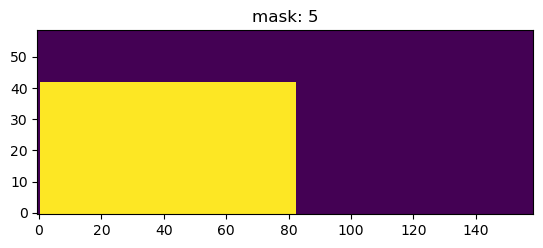

In [25]:
ii = 1
a = 0
b = 20
masks = results
y0 = masks[ii]['bbox'][0] - a
x0 = masks[ii]['bbox'][1] - b
x1 = x0 + masks[ii]['bbox'][3] + b
y1 = y0 + masks[ii]['bbox'][2] + a

# generate as sparse matrix when things get big
bbox = np.zeros(masks[ii]['segmentation'].shape)

bbox[x0:x1, y0:y1] = 1
# bbox[x1, y1] = 1

flatten = bbox # masks[ii]['segmentation'].flatten(order='F')
reshape = flatten.reshape(meshCore.shape_cells, order='F')

plt.imshow(reshape.T)
plt.title(f'mask: {cnt + 1}')
plt.gca().invert_yaxis()
# plt.plot([x0, x1], [y0, y1], 'ok')
plt.show()

In [32]:
masks[ii]['bbox']

[0, 32, 42, 63]

/tmp/ipykernel_33480/4256984234.py:4: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)


(<matplotlib.contour.QuadContourSet at 0x78736b6e5fd0>,
 <Axes: title={'center': 'Mask 2: Bounding box'}, xlabel='x', ylabel='y'>,
 <matplotlib.contour.QuadContourSet at 0x78736b6e78d0>)

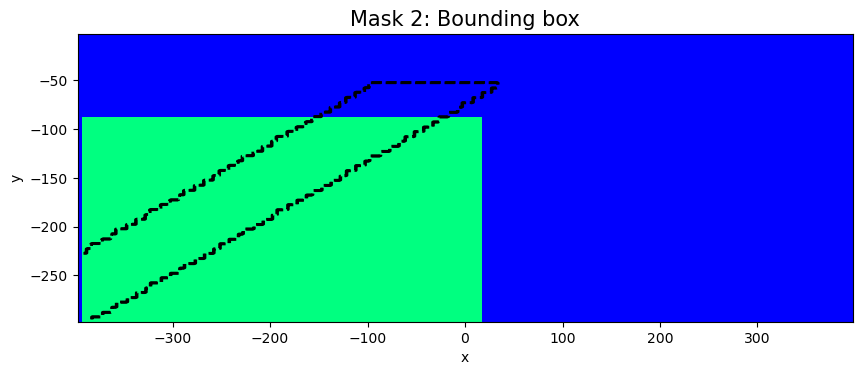

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
# dat = meshCore.plotImage(1 / np.exp(geological_model), ax=ax, clim=[10, 500], pcolorOpts={'cmap':"Spectral"})
flatten = reshape.flatten(order='F')  # (cond_true)[actcore]
dat = meshCore.plotImage(1 / np.exp(flatten), ax=ax, pcolorOpts={'cmap':"winter_r"})
ax.set_title(f'Mask {ii+1}: Bounding box',fontsize=15)
# plt.colorbar(dat[0])

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax,
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

In [27]:
np.save('rotation_block_mask_scaled.npy', flatten)

In [19]:
flatten.shape

(9381,)